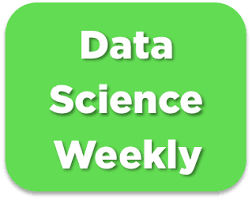

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
#from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import seaborn as sns

# Read file with labels

In [12]:
df = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', df.shape)

Set with labels (our train+test) : (284580, 6)


In [13]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [14]:
#Basic stats
print("Number of rows : {}".format(df.shape[0]))
print("Number of columns : {}".format(df.shape[1]))
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 284580
Number of columns : 6

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

# Explore dataset

In [90]:
fig = px.pie(df, names=["Converted", "Not Converted"], values=df.converted.value_counts())
     
fig.update_layout(title={
        'text': "Conversion repartition",
        'y':0.98,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'},
        margin=dict(l=50,r=50,b=50,t=50,pad=4), 
        template = 'plotly_dark'
        )   
fig.show()

In [91]:
max_age=df['age'].mean() + 3*df['age'].std()
max_totalPages=df['total_pages_visited'].mean() + 3*df['total_pages_visited'].std()

print('Nous pouvons considérer comme outliers dans notre dataset, les valeurs qui seraient supérieures à')
print(f'Age = {max_age}, total pages visited = {max_totalPages}')
min_age=df['age'].mean() - 3*df['age'].std()
min_totalPages=df['total_pages_visited'].mean() - 3*df['total_pages_visited'].std()

print('Nous pouvons considérer comme outliers dans notre dataset, les valeurs qui seraient inférieures à')
print(f'Age = {min_age}, total pages visited  = {min_totalPages}')

Nous pouvons considérer comme outliers dans notre dataset, les valeurs qui seraient supérieures à
Age = 55.36457159268994, total pages visited = 14.899235385871771
Nous pouvons considérer comme outliers dans notre dataset, les valeurs qui seraient inférieures à
Age = 5.763835182206396, total pages visited  = -5.1527317665028765


In [7]:
print('Nous avons des outliers dans la colonne Age et dans la colonne total pages visited')

Nous avons des outliers dans la colonne Age et dans la colonne total pages visited


In [211]:
((sum(df['age']>80))/len(df))*100

0.0007027900766041184

<AxesSubplot:xlabel='age'>

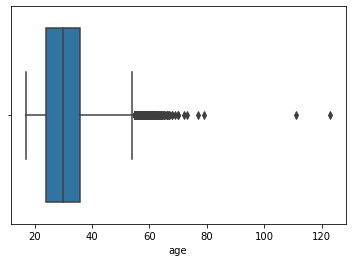

In [193]:
#Visualisation des Outliers 
sns.boxplot(x=df["age"])

<AxesSubplot:xlabel='total_pages_visited'>

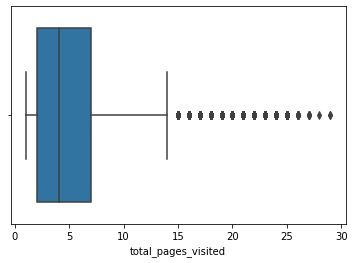

In [194]:
#Visualisation des Outliers 
sns.boxplot(x=df["total_pages_visited"])

In [195]:
((sum(df['total_pages_visited']>15))/len(df))*100

1.377819945182374

In [212]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = df.sample(10000)

In [213]:
# Visualize pairwise dependencies
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [214]:
# Correlation matrix
corr_matrix = df.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

In [199]:
#je compte combien de lignes je vais devoir supprimer = 5
#(df['age'] > df['age'].mean() + 3*df['age'].std()).value_counts()

In [200]:
#je compte combien de lignes je vais devoir supprimer = 5
#(df['total_pages_visited'] > df['total_pages_visited'].mean() + 3*df['total_pages_visited'].std()).value_counts()

In [80]:
# Suppression des lignes contenant des outliers dans Unemployment (using masks) (je garde les valeurs nulles)

print('Dropping outliers in Unemployment...')
to_keep = (df['age'] < 80)| (df['age'].isnull())
df = df.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

Dropping outliers in Unemployment...
Done. Number of lines remaining :  284578



In [202]:
# Suppression des lignes contenant des outliers dans Unemployment (using masks) (je garde les valeurs nulles)

#print('Dropping outliers in Unemployment...')
#to_keep = (df['total_pages_visited'] < (df['total_pages_visited'].mean() + 3*df['total_pages_visited'].std())) | (df['total_pages_visited'].isnull())
#df = df.loc[to_keep,:]
#print('Done. Number of lines remaining : ', df.shape[0])
#print()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [81]:
X = df.drop("converted", axis=1)
y = df["converted"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state = 0 ,stratify = y)

In [82]:
numeric_features = ['age','total_pages_visited']
categorical_features = ['country', 'source','new_user']

In [84]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
#print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [ ]:
# Correlation matrix
corr_matrix = pd.DataFrame(X_train).corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

## Training pipeline

In [ ]:
#test modele internet

In [ ]:
scores_df = pd.DataFrame(columns = ['model', 'accuracy', 'F1', 'set'])

In [ ]:
#### Logistic
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("...Done.")


Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.5077476913444984
f1-score on test set :  0.4715909090909091


In [12]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [ 3.5, 8,10,15,20,30], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))


Grid search...
{'base_estimator__C': [3.5, 8, 10, 15, 20, 30], 'n_estimators': [5, 10, 20, 30]}
...Done.
Best hyperparameters :  {'base_estimator__C': 3.5, 'n_estimators': 10}
Best validation accuracy :  0.9862603318332053

Accuracy on training set :  0.9862735107308203
Accuracy on test set :  0.986190174994729


In [13]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.7649138644399308
f1-score on test set :  0.7646706586826348


In [28]:
#last tes
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [ 0.1,0.5,1.5,2,2.5,3.5,4,4.5,5], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [8,10,12,15] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearchbag = GridSearchCV(model, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearchbag.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchbag.best_params_)
print("Best validation accuracy : ", gridsearchbag.best_score_)
print()
print("Accuracy on training set : ", gridsearchbag.score(X_train, y_train))
print("Accuracy on test set : ", gridsearchbag.score(X_test, y_test))


Grid search...
{'base_estimator__C': [0.1, 0.5, 1.5, 2, 2.5, 3.5, 4, 4.5, 5], 'n_estimators': [8, 10, 12, 15]}
...Done.
Best hyperparameters :  {'base_estimator__C': 3.5, 'n_estimators': 10}
Best validation accuracy :  0.9862559396074573

Accuracy on training set :  0.9862471558714234
Accuracy on test set :  0.9861374657389838


In [29]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.7634660421545668
f1-score on test set :  0.7632763276327632


In [44]:
#last tes
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [3.5,6,7], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [10,12] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))


Grid search...
{'base_estimator__C': [3.5, 6, 7], 'n_estimators': [10, 12]}
...Done.
Best hyperparameters :  {'base_estimator__C': 3.5, 'n_estimators': 12}
Best validation accuracy :  0.9862427622549325

Accuracy on training set :  0.9862471558714234
Accuracy on test set :  0.9861550354908989


In [51]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.764036475996684
f1-score on test set :  0.7639304973037746


In [52]:
print(classification_report(y_true = y_test, y_pred=Y_test_pred ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.69      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.85      0.88     56916
weighted avg       0.99      0.99      0.99     56916



In [31]:
df_test=pd.read_csv('conversion_data_test.csv')

In [32]:
df_test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [33]:
print('Dropping outliers in Unemployment...')
to_keep = (df_test['age'] < 80)| (df_test['age'].isnull())
df = df_test.loc[to_keep,:]
print('Done. Number of lines remaining : ', df.shape[0])
print()

Dropping outliers in Unemployment...
Done. Number of lines remaining :  31620



In [40]:
features_list= df_test.columns
X = df.loc[:,features_list] 

In [41]:
numeric_features = ['age','total_pages_visited']
categorical_features = ['country', 'source','new_user']

In [42]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings 
print("Performing preprocessings on train set...")

X = preprocessor.fit_transform(X)
print('...Done.')



Performing preprocessings on train set...
...Done.


In [46]:
print("Predictions on test file...")
pred = gridsearch.predict(X)
print("...Done.")

Predictions on test file...
...Done.


In [47]:
pred

array([1, 0, 0, ..., 0, 1, 0])

In [48]:
pred = pd.DataFrame(pred)
#take id column from test_data(given test.csv) and concat with pred =>
pred.to_csv("conversion_data_test_predictions_[Feriel].csv")

In [14]:
# Fonctionne mieux
print("Grid search...")
logistic_regression = LogisticRegression() # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [20,25,30,35,40,50], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [55,60,65,70,80] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch2 = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch2.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch2.best_params_)
print("Best validation accuracy : ", gridsearch2.best_score_)
print()
print("Accuracy on training set : ", gridsearch2.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch2.score(X_test, y_test))


Grid search...
{'base_estimator__C': [20, 25, 30, 35, 40, 50], 'n_estimators': [55, 60, 65, 70, 80]}
...Done.
Best hyperparameters :  {'base_estimator__C': 20, 'n_estimators': 70}
Best validation accuracy :  0.9862120160969498

Accuracy on training set :  0.9862076235823282
Accuracy on test set :  0.9860320472274932


In [15]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch2.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch2.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.7635542168674699
f1-score on test set :  0.7627573858549687


In [85]:
#adaboost avec trees (dernier test 13h12)
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
adaboost_dt = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [4,5,6],
    'base_estimator__min_samples_leaf': [4,5,6],
    'base_estimator__min_samples_split': [9,10,12],
    'class_weight': ["balanced"],
    'n_estimators': [4, 6, 8]
}
print(params)
gridsearchdtada = GridSearchCV(adaboost_dt, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearchdtada.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchdtada.best_params_)
print("Best validation accuracy : ", gridsearchdtada.best_score_)
print()
print("Accuracy on training set : ", gridsearchdtada.score(X_train, y_train))
print("Accuracy on test set : ", gridsearchdtada.score(X_test, y_test))

Grid search...
{'base_estimator__max_depth': [4, 5, 6], 'base_estimator__min_samples_leaf': [4, 5, 6], 'base_estimator__min_samples_split': [9, 10, 12], 'class_weight': ['balanced'], 'n_estimators': [4, 6, 8]}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/t3/rkks8m514635lhc10vfq7kn80000gn/T/ipykernel_1081/1159415512.py", line 17, in <cell line: 17>
    gridsearchdtada.fit(X_train, y_train)
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 891, in fit
    self.best_index_ = self._select_best_index(
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 838, in evaluate_candidates
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/macbook/opt/anaconda3/lib/python3.

In [17]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearchdtada.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearchdtada.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.7685074626865671
f1-score on test set :  0.7564368156259247


In [49]:
# Perform grid search = dernier xgboost lancé apres avoir soumis
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6],
    'min_child_weight': [2,3,4],
    'n_estimators': [35,36,37]
}
print(params)
gridsearchxg = GridSearchCV(xgboost, param_grid = params, cv = 5, verbose = 1) # cv : the number of folds to be used for CV
gridsearchxg.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchxg.best_params_)
print("Best validation accuracy : ", gridsearchxg.best_score_)
print()
print("Accuracy on training set : ", gridsearchxg.score(X_train, y_train))
print("Accuracy on test set : ", gridsearchxg.score(X_test, y_test))

Grid search...
{'max_depth': [4, 6], 'min_child_weight': [2, 3, 4], 'n_estimators': [35, 36, 37]}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 35}
Best validation accuracy :  0.9862515469958344

Accuracy on training set :  0.9863569677855769
Accuracy on test set :  0.9858739194602573


In [50]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearchxg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearchxg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


print("f1-score on training set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on training set :  0.7669567827130852
f1-score on test set :  0.7608566329565736


In [53]:
print(classification_report(y_true = y_test, y_pred=Y_test_pred ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.69      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.85      0.88     56916
weighted avg       0.99      0.99      0.99     56916



In [ ]:
print(classification_report(y_true = y_test, y_pred=Y_test_pred ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     68465
           1       0.69      0.41      0.51      1148

    accuracy                           0.99     69613
   macro avg       0.84      0.70      0.75     69613
weighted avg       0.99      0.99      0.99     69613



## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.63778957]
 [ 0.03879562]
 [-0.26070136]
 [-0.26070136]
 [ 0.63778957]]


In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6938517686692869
f1-score on test set :  0.7060240963855423


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246817   1082]
 [  3280   4943]]

Confusion matrix on test set : 
[[27384   117]
 [  371   586]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**